# Notebook 1.B

## Backprop and vanishing gradient

In the previous notebook we created synthethic data thjat was generated by a function plus some noise and we tried to recover this function. By analysing this example, we will get some cruxial insight int how neural networks learn!

Some of the functions in notebook Nb.1.A are also implemented in the files helpers.py  - we will import them below, together with our usual libs

In [227]:
# import pytorch
import torch
from torch import nn
import numpy as np
# import from helpers
from helpers import f, obs, MSE
# use type indicators
from typing import Callable
# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# padas data frame
import pandas as pd
# deep copy for copying model
from copy import deepcopy

from helpers import Tracking # helps us tracking the model weights for visualizaiton!

#%matplotlib notebook

In [228]:
sns.set_theme()
sns.set_style("darkgrid")

To make our lifes easier, we again implement the fully connected network. This time however, the number of layers and the activation function will be a parameter. Thanks to the nn.Sequential class this is not hard at all 

# Implementing a PyTorch model

In [333]:
class NoneLinearModel_Explicit0(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(NoneLinearModel_Explicit0, self).__init__()
        self.input_layer = nn.Linear(in_features=input_dim, out_features=100)
        self.hidden_l1 = nn.Linear(in_features=100, out_features=50)
        self.hidden_l2 = nn.Linear(in_features=50, out_features=25)
        self.out_layer = nn.Linear(in_features=25, out_features=output_dim)
        
        
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_l1(x))
        x = torch.relu(self.hidden_l2(x))
        x = self.out_layer(x)
        return x        

In [334]:
net0 = NoneLinearModel_Explicit0(1,1)
net0

NoneLinearModel_Explicit0(
  (input_layer): Linear(in_features=1, out_features=100, bias=True)
  (hidden_l1): Linear(in_features=100, out_features=50, bias=True)
  (hidden_l2): Linear(in_features=50, out_features=25, bias=True)
  (out_layer): Linear(in_features=25, out_features=1, bias=True)
)

Implement a model using nn.Sequential

In [336]:
class NoneLinearModel_Explicit1(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(NoneLinearModel_Explicit1, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=25),
            nn.ReLU(),
            nn.Linear(in_features=25, out_features=output_dim),
        )
             
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x = self.layers(x)
        return x 

In [337]:
net1 = NoneLinearModel_Explicit1(1,1)
net1

NoneLinearModel_Explicit1(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
)

Implement a model using nn.Sequential: why?

In [230]:
class NonLinearModel(torch.nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 n_intermediate: int,
                 intermediate_dim: int, 
                 output_dim: int,
                 act_fun: nn.Module) -> None:
        super(NonLinearModel, self).__init__()
        
        # we will store all our layers/operations here
        self.layers = torch.nn.Sequential()
        
        if n_intermediate > 0:  
            # add input layer
            self.layers.append(nn.Linear(in_features=input_dim, 
                                         out_features=intermediate_dim))
        
            # add intermediate layers and activation functions
            for _ in range(n_intermediate-1):
                self.layers.append(act_fun)
                self.layers.append(nn.Linear(in_features=intermediate_dim, 
                                             out_features=intermediate_dim))
        
            # add  output layer
            self.layers.append(act_fun)
            self.layers.append(nn.Linear(in_features=intermediate_dim, 
                                         out_features=output_dim))
        else:
            self.layers.append(nn.Linear(in_features=input_dim, 
                                         out_features=output_dim))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # execute all operations
        out = self.layers(x)
        return out

Lets try out the new model - instead of making the network wider like in the last notebook, lets make it deeper  

NonLinearModel(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Sequential()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sequential()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): Sequential()
    (6): Linear(in_features=2, out_features=2, bias=True)
    (7): Sequential()
    (8): Linear(in_features=2, out_features=2, bias=True)
    (9): Sequential()
    (10): Linear(in_features=2, out_features=2, bias=True)
    (11): Sequential()
    (12): Linear(in_features=2, out_features=2, bias=True)
    (13): Sequential()
    (14): Linear(in_features=2, out_features=2, bias=True)
    (15): Sequential()
    (16): Linear(in_features=2, out_features=2, bias=True)
    (17): Sequential()
    (18): Linear(in_features=2, out_features=2, bias=True)
    (19): Sequential()
    (20): Linear(in_features=2, out_features=2, bias=True)
    (21): Sequential()
    (22): Linear(in_features=2, out_features=2, bias=True)
    (23):

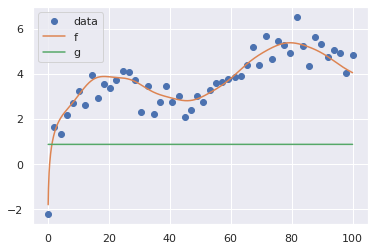

In [231]:
# Let's instantiate the new model function
net = NonLinearModel(input_dim=1,
                     n_intermediate=12, # number of hidden leayers
                     intermediate_dim=2, # number of neurons per hidden layer 
                     output_dim=1,
                     act_fun=nn.Sequential()) # let us start with sigmoid activation
print(net)

# and lets apply the function on our data and plot it
N_datapoints = 50
x = torch.linspace(0.1,100,N_datapoints)
y = obs(x)
out = net(x.view(-1,1))

interval = torch.linspace(0.1,100,1000) 
fx = f(interval) 
plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
plt.show()

In [232]:
# get weight tracker
tracker = Tracking()

optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001)

n_epoch = 10000
loss_array = []
fx_diff = []
fx_epoch = []

track_every = 500
for epoch in range(n_epoch):
    # track current weight
    if epoch % track_every == 0:
        print(epoch)
        tracker.update(epoch=epoch, net=net)
    
    # set all gradients to zero
    net.zero_grad()
    
    # apply neural network on all data points
    out = net(x.view(-1,1))
    
    # calculate loss
    loss = MSE(y=y, gx=out.view(-1))
    
    # calculate gradients
    loss.backward()
    
    # one step along the steppest descent
    optimizer.step()
    
    
    # apply model on interval to calc diff to f
    if epoch % track_every == 0:
         # store loss vor visualization
        loss_array.append(loss.item())
        # apply model on interval to calc diff to f
        with torch.no_grad():
            out_f = net(interval.view(-1,1))
            diff = ((out_f.view(-1) - fx.view(-1)).abs()).mean()
            fx_diff.append(diff.item())
            fx_epoch.append(epoch)
    if epoch % track_every == 0:
        print(f'\r[{epoch}/{n_epoch}]: loss = {loss}', end="")

0
[0/10000]: loss = 9.8796968460083500
[500/10000]: loss = 1.47768247127532961000
[1000/10000]: loss = 0.93055653572082521500
[1500/10000]: loss = 0.91130846738815312000
[2000/10000]: loss = 0.91024035215377812500
[2500/10000]: loss = 0.91017198562622073000
[3000/10000]: loss = 0.91016775369644173500
[3500/10000]: loss = 0.91016721725463874000
[4000/10000]: loss = 0.91016721725463874500
[4500/10000]: loss = 0.91016709804534915000
[5000/10000]: loss = 0.91016715764999395500
[5500/10000]: loss = 0.91016715764999396000
[6000/10000]: loss = 0.91016709804534916500
[6500/10000]: loss = 0.91016709804534917000
[7000/10000]: loss = 0.91016721725463877500
[7500/10000]: loss = 0.91016721725463878000
[8000/10000]: loss = 0.91016709804534918500
[8500/10000]: loss = 0.91016709804534919000
[9000/10000]: loss = 0.91016715764999399500
[9500/10000]: loss = 0.9101670980453491

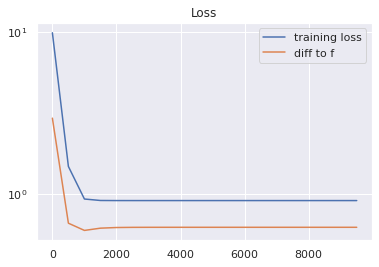

In [233]:
plt.close()    
plt.yscale('log')
plt.title('Loss')
plt.plot(fx_epoch,loss_array, label='training loss')
plt.plot(fx_epoch, fx_diff, label='diff to f')
plt.legend()
plt.show()

 plotting epoch 19

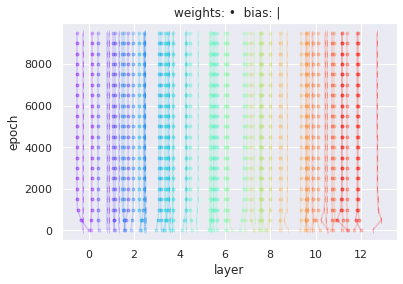

In [234]:
plt.close()
tracker.plot(alpha=0.2, 
             overlay=False, 
             params=['bias', 'weight'], 
             save_at="/tmp/out.pdf")

 plotting epoch 19

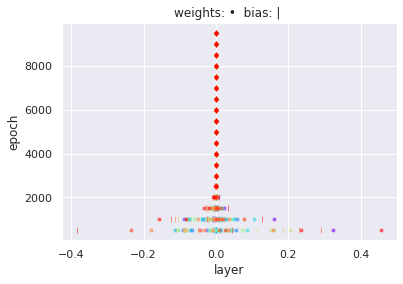

In [235]:
plt.close()
tracker.plot_diff(alpha=0.5, overlay=True, params=['bias', 'weight'])

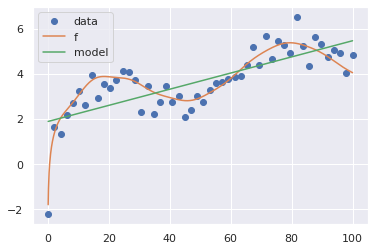

In [236]:
out = net(x.view(-1,1))

plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='model')
plt.legend()
plt.show()

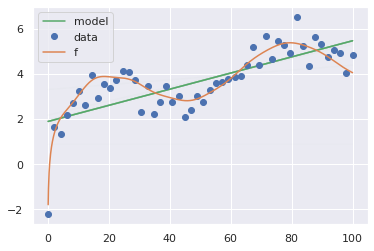

In [237]:
plt.close()
tracker.plot_models(x, y, interval, fx, net,color='g')

# Tracking gradients

Accessing the weights of the parameters

In [238]:
# plot tensors
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1247],
        [-0.5245]], requires_grad=True)
Parameter containing:
tensor([ 0.8954, -0.2635], requires_grad=True)
Parameter containing:
tensor([[ 0.0867,  0.7359],
        [-0.5881,  0.1613]], requires_grad=True)
Parameter containing:
tensor([-0.1919,  0.3297], requires_grad=True)
Parameter containing:
tensor([[-0.5233, -0.4620],
        [ 0.4194, -0.0421]], requires_grad=True)
Parameter containing:
tensor([0.4996, 0.4692], requires_grad=True)
Parameter containing:
tensor([[ 0.0897,  0.1638],
        [ 0.4945, -0.7793]], requires_grad=True)
Parameter containing:
tensor([ 0.5558, -0.5496], requires_grad=True)
Parameter containing:
tensor([[-0.5975, -0.6514],
        [-0.3041,  0.3018]], requires_grad=True)
Parameter containing:
tensor([-0.2899,  0.2848], requires_grad=True)
Parameter containing:
tensor([[ 0.5101,  0.6399],
        [ 0.4919, -0.5522]], requires_grad=True)
Parameter containing:
tensor([ 0.4020, -0.1985], requires_grad=True)
Parameter co

In [239]:
# plot tensors
for p in net.named_parameters():
    print(p)

('layers.0.weight', Parameter containing:
tensor([[ 0.1247],
        [-0.5245]], requires_grad=True))
('layers.0.bias', Parameter containing:
tensor([ 0.8954, -0.2635], requires_grad=True))
('layers.2.weight', Parameter containing:
tensor([[ 0.0867,  0.7359],
        [-0.5881,  0.1613]], requires_grad=True))
('layers.2.bias', Parameter containing:
tensor([-0.1919,  0.3297], requires_grad=True))
('layers.4.weight', Parameter containing:
tensor([[-0.5233, -0.4620],
        [ 0.4194, -0.0421]], requires_grad=True))
('layers.4.bias', Parameter containing:
tensor([0.4996, 0.4692], requires_grad=True))
('layers.6.weight', Parameter containing:
tensor([[ 0.0897,  0.1638],
        [ 0.4945, -0.7793]], requires_grad=True))
('layers.6.bias', Parameter containing:
tensor([ 0.5558, -0.5496], requires_grad=True))
('layers.8.weight', Parameter containing:
tensor([[-0.5975, -0.6514],
        [-0.3041,  0.3018]], requires_grad=True))
('layers.8.bias', Parameter containing:
tensor([-0.2899,  0.2848], r

In [240]:
print(p[0])
print(p[1])

layers.24.bias
Parameter containing:
tensor([0.7257], requires_grad=True)


In [241]:
# plot last calculated gradients of tensors
for p in net.parameters():
    print(p.grad)

tensor([[-4.9523e-07],
        [ 2.7353e-06]])
tensor([ 7.0140e-08, -4.0047e-07])
tensor([[-2.6077e-08, -1.6764e-06],
        [-1.8626e-09, -6.4075e-07]])
tensor([-5.0338e-07, -1.9325e-07])
tensor([[ 1.1101e-06,  3.9861e-07],
        [-1.4082e-06, -5.2899e-07]])
tensor([ 4.7544e-07, -6.0536e-07])
tensor([[-4.7684e-07,  6.5938e-07],
        [-9.2387e-07,  1.2480e-06]])
tensor([4.7218e-07, 8.7731e-07])
tensor([[-7.4506e-07,  2.2873e-06],
        [ 3.9395e-07, -1.2778e-06]])
tensor([-1.0785e-06,  5.7090e-07])
tensor([[-3.7253e-07,  3.0175e-07],
        [-1.2219e-06,  9.3505e-07]])
tensor([-5.2294e-07, -1.6391e-06])
tensor([[ 1.8580e-07,  2.1979e-07],
        [-8.0466e-07, -9.9093e-07]])
tensor([ 4.6333e-07, -1.9874e-06])
tensor([[-2.6487e-06,  7.4506e-08],
        [-9.3319e-07,  7.4506e-09]])
tensor([2.9095e-06, 1.0319e-06])
tensor([[-1.5795e-06,  5.3644e-07],
        [-1.2964e-06,  4.6194e-07]])
tensor([-2.6561e-06, -2.2985e-06])
tensor([[ 1.0710e-07, -7.0781e-08],
        [ 8.1956e-07, 

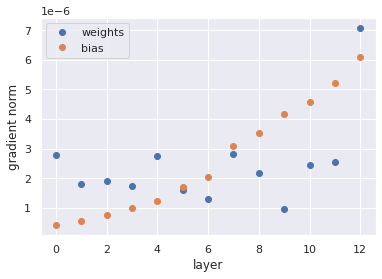

In [242]:
# get norms of gradients
norm_weight = []
norm_bias = []
for p in net.named_parameters():
    if 'weight' in p[0]:
        norm_weight.append(p[1].grad.norm())
    else:
        norm_bias.append(p[1].grad.norm())
plt.plot(norm_weight, 'o', label='weights')
plt.plot(norm_bias, 'o', label='bias')
plt.xlabel('layer')
plt.ylabel('gradient norm')
plt.legend()
plt.show()

# Tracking deltas
Reminder: we refer to the derivative dL/dh (where h is the pre-activation) as deltas
This means we need to explicitely track the preactivations in the network

In [299]:
class NoneLinearModel_Explicit2(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(NoneLinearModel_Explicit2, self).__init__()
        self.input_layer = nn.Linear(in_features=input_dim, out_features=20)
        self.hidden_l1 = nn.Linear(in_features=20, out_features=10)
        self.out_layer = nn.Linear(in_features=10, out_features=output_dim)
        
        # for tracking the deltas
        self.deltas = []
       
    def save_delta(self):
        def hook(grad):
            self.deltas[-1].append(grad)
        return hook
        
        
    def forward(self, x: torch.tensor) -> torch.Tensor:
        
        # forward pass that tracks pre activation
        h0 = self.input_layer(x)
        
        if h0.requires_grad:
            self.deltas.append([])
            h0.register_hook(self.save_delta())
        a0 = torch.relu(h0)
        
        h1 = self.hidden_l1(a0)
        if h1.requires_grad:
            h1.register_hook(self.save_delta())
        a1 = torch.relu(h1)
        
        out = self.out_layer(a1)
        if out.requires_grad:
            out.register_hook(self.save_delta())
        
        return out

NoneLinearModel_Explicit2(
  (input_layer): Linear(in_features=1, out_features=20, bias=True)
  (hidden_l1): Linear(in_features=20, out_features=10, bias=True)
  (out_layer): Linear(in_features=10, out_features=1, bias=True)
)


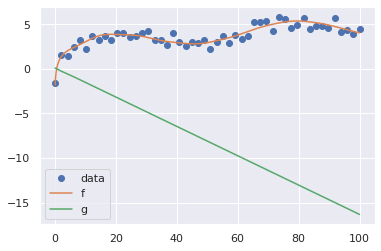

In [328]:
# Let's instantiate the new model function
net2 = NoneLinearModel_Explicit2(input_dim=1, output_dim=1)
print(net2)

# and lets apply the function on our data and plot it
N_datapoints = 50
x = torch.linspace(0.1,100,N_datapoints)
y = obs(x)
with torch.no_grad():
    out = net2(x.view(-1,1))

interval = torch.linspace(0.1,100,1000) 
fx = f(interval) 
plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
plt.show()

In [329]:
# get weight tracker
tracker = Tracking()

#optimizer = torch.optim.SGD(params=net2.parameters(), lr=0.005)
optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.1)

n_epoch = 5000
loss_array = []
fx_diff = []
fx_epoch = []

track_every = 500
for epoch in range(n_epoch):
    # track current weight
    if epoch % track_every == 0:
        print(epoch)
        tracker.update(epoch=epoch, net=net)
    
    # set all gradients to zero
    net2.zero_grad()
    
    # apply neural network on all data points
    out = net2(x.view(-1,1))
    
    # calculate loss
    loss = MSE(y=y, gx=out.view(-1))
    
    # calculate gradients
    loss.backward()
    
    # one step along the steppest descent
    optimizer.step()
    
    
    # apply model on interval to calc diff to f
    if epoch % track_every == 0:
         # store loss vor visualization
        loss_array.append(loss.item())
        # apply model on interval to calc diff to f
        with torch.no_grad():
            out_f = net2(interval.view(-1,1))
            diff = ((out_f.view(-1) - fx.view(-1)).abs()).mean()
            fx_diff.append(diff.item())
            fx_epoch.append(epoch)
    if epoch % track_every == 0:
        print(f'\r[{epoch}/{n_epoch}]: loss = {loss}', end="")

0
[0/5000]: loss = 173.49456787109375500
[500/5000]: loss = 0.54939019680023191000
[1000/5000]: loss = 0.53882944583892821500
[1500/5000]: loss = 0.53367704153060912000
[2000/5000]: loss = 0.53326886892318732500
[2500/5000]: loss = 0.53170090913772583000
[3000/5000]: loss = 0.55351674556732183500
[3500/5000]: loss = 0.51903837919235234000
[4000/5000]: loss = 0.51848268508911134500
[4500/5000]: loss = 0.5184826850891113

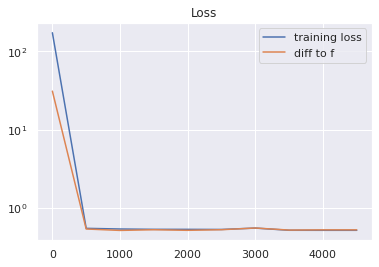

In [330]:
plt.close()    
plt.yscale('log')
plt.title('Loss')
plt.plot(fx_epoch,loss_array, label='training loss')
plt.plot(fx_epoch, fx_diff, label='diff to f')
plt.legend()
plt.show()

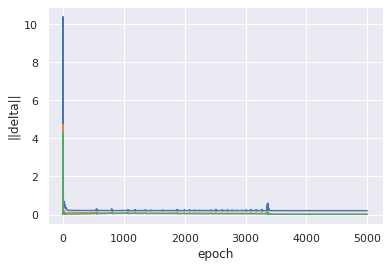

In [331]:
ndeltas_1 = []
ndeltas_2 = []
ndeltas_3 = []

for deltas in net2.deltas:
    if len(deltas) == 3:
        ndeltas_1.append(deltas[0].norm().item())
        ndeltas_2.append(deltas[1].norm().item())
        ndeltas_3.append(deltas[2].norm().item())

plt.plot(ndeltas_1)
plt.plot(ndeltas_2)
plt.plot(ndeltas_3)
plt.xlabel('epoch')
plt.ylabel('||delta||')
plt.show()

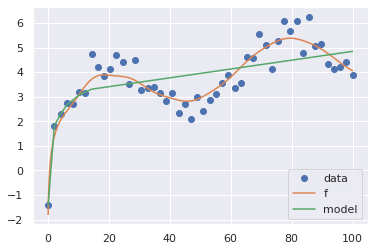

In [325]:
with torch.no_grad():
    out = net2(x.view(-1,1))

plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='model')
plt.legend()
plt.show()

# Initialization
We can add our own initalization method to a model

In [352]:
class NoneLinearModel_Init(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(NoneLinearModel_Init, self).__init__()
        self.input_layer = nn.Linear(in_features=input_dim, out_features=100)
        self.hidden_l1 = nn.Linear(in_features=100, out_features=50)
        self.hidden_l2 = nn.Linear(in_features=50, out_features=25)
        self.out_layer = nn.Linear(in_features=25, out_features=output_dim)
        
        
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.hidden_l1(x))
        x = torch.tanh(self.hidden_l2(x))
        x = self.out_layer(x)
        return x
    
    def init_xavier(self):
        params = list(self.named_parameters())
        n_params = len(params)
        for i, p in enumerate(params):
            print(f'\r initializing parameter [{i+1}/{n_params}]', end="")
            if 'bias' in p[0]:
                p[1].data.zero_()
            elif 'weight' in p[0]:
                fan_out, fan_in = p[1].shape
                std = np.sqrt(2/(fan_in + fan_out))
                p[1].data.normal_(std=std)
                
                
        

In [358]:
net_i = NoneLinearModel_Init(1,1)

In [359]:
net_i.input_layer.bias

Parameter containing:
tensor([ 0.2463,  0.0041,  0.7375, -0.1538, -0.3519, -0.7595, -0.5615, -0.9350,
        -0.6108, -0.1794, -0.9719,  0.9427, -0.1614,  0.3629,  0.1510, -0.1600,
         0.9657,  0.4685, -0.9882,  0.0830,  0.4576,  0.5203, -0.7082,  0.4536,
         0.5389,  0.6173,  0.6330,  0.6502, -0.6036, -0.2414,  0.5485, -0.4759,
         0.6251, -0.7505, -0.2899,  0.8282,  0.2033,  0.1772,  0.9909, -0.9064,
         0.3916,  0.3555,  0.6396, -0.3288,  0.7904, -0.9236, -0.1295, -0.3784,
        -0.6757, -0.7368,  0.1925,  0.9127, -0.5318,  0.1175,  0.3115, -0.0300,
         0.6583, -0.4075, -0.4861, -0.9194, -0.3070,  0.3205, -0.4074,  0.6986,
        -0.7907, -0.5220, -0.0656, -0.4067,  0.4752,  0.7138, -0.5247,  0.7522,
         0.9095, -0.1331, -0.4763,  0.6954,  0.8119, -0.0057,  0.2874,  0.1739,
         0.9198,  0.4718,  0.0995, -0.9228,  0.0675,  0.8814,  0.2393, -0.2222,
         0.1765,  0.2088,  0.3350, -0.5180, -0.9074, -0.6827,  0.7066, -0.5799,
         0.0049, -

In [360]:
net_i.init_xavier()

 initializing parameter [8/8]

In [361]:
net_i.input_layer.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True)